In [63]:
import spacy
import pandas as pd
import numpy as np
from glob import glob
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import randint
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
from math import floor
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

In [2]:
bib = pd.read_csv('bibliography/everyone.csv')

In [3]:
authorDfList = list(bib.groupby('author'))

In [16]:
authorDfDict = {author: df for author, df in authorDfList}

In [17]:
authorList = list(authorDfDict.keys())

In [71]:
len(authorList)

51

In [18]:
class textPieces(): 
    def __init__(self, author, df, sample=True, pieces=2): 
        self.author = author
        self.df = df
        self.labels = []
        for i, row in df.iterrows():
            try: 
                age = int(row.age)
            except: 
                age = str(row.age)
            try:
                ytd = int(row.yearsToDeath)
            except: 
                ytd = str(row.yearsToDeath)
            self.labels.append('%d-%s-%s-%s' % (row.date, age, ytd, row.title))
        self.texts = [self.getText(bookID) for bookID in df['id']]
        # Prune those where texts can't be found
        prunedTexts, prunedLabels = [], []
        for label, text in zip(self.labels, self.texts): 
            if text is not None: 
                prunedTexts.append(text)
                prunedLabels.append(label)
        self.texts = prunedTexts
        self.labels = prunedLabels
        self.lengths = [len(text) for text in self.texts]
        self.lowestLength = min(self.lengths)
#         print('Using texts: ', self.labels)
        if sample: 
            self.samples = [self.sample(text) for text in self.texts]
        else: 
            self.samples = self.texts
        if pieces > 1: 
            self.pieces = []
            self.makePieces(self.labels, self.samples, pieces)
        else: 
            self.pieces = self.texts
        
    def getText(self, bookID):
        database = 'sqlite:////home/jon/Code/gitenberg-scrape/pg-text-7.db'
        query = 'select text from text where id = ' + str(round(float(bookID)))
        df = pd.read_sql(query, database)
        if len(df) > 0: 
            return df.text[0]
        else:
            return None
        
    def sample(self, text): 
        """ Randomly samples from texts that are long, 
        so that we're comparing the same amount of text across documents."""
        chunkSize = self.lowestLength
        # We want a chunk of [a:b] where the max value of b is end-chunkSize
        textLength = len(text)
        maxEnd = textLength - chunkSize
        if maxEnd <= 0: 
            return text
        start = randint(0, maxEnd)
        return text[start:start+chunkSize]
    
    def makePieces(self, labels, samples, n): 
        pieceSize = self.lowestLength / n
        self.labels = []
        for label, sample in zip(labels, samples): 
            for i in range(n):
                pieceLabel = "%s-%s" % (label, i)
                start = int(i*pieceSize)
                end = int(start+pieceSize)
#                 print('Piece start: %s, piece end: %s' % (start, end))
                piece = sample[start:end]
                self.labels.append(pieceLabel)
                self.pieces.append(piece)

In [19]:
tp = textPieces(author, df)

In [20]:
tp.texts[0][:500]

'\n\n\n\n\nTHE BRITISH BARBARIANS\n\nA HILL-TOP NOVEL\n\n\nBy Grant Allen\n\n1895\n\n\n\n\nINTRODUCTION\n\n\nWhich every reader of this book is requested to read before beginning\nthe story.\n\n\nThis is a Hill-top Novel. I dedicate it to all who have heart enough,\nbrain enough, and soul enough to understand it.\n\nWhat do I mean by a Hill-top Novel? Well, of late we have been flooded\nwith stories of evil tendencies: a Hill-top Novel is one which raises a\nprotest in favour of purity.\n\nWhy have not novelists raised the pro'

In [21]:
tp.labels

['1895-47-4-The British Barbarians-0',
 '1895-47-4-The British Barbarians-1',
 '1895-47-4-The Woman Who Did-0',
 '1895-47-4-The Woman Who Did-1',
 "1893-45-6-Michael's Crag-0",
 "1893-45-6-Michael's Crag-1",
 "1891-43-8-What's Bred in the Bone-0",
 "1891-43-8-What's Bred in the Bone-1",
 '1884-36-15-Philistia-0',
 '1884-36-15-Philistia-1',
 '1891-43-8-The Great Taboo-0',
 '1891-43-8-The Great Taboo-1',
 '1894-46-5-Post-Prandial Philosophy-0',
 '1894-46-5-Post-Prandial Philosophy-1',
 "1899-51-0-Miss Cayley's Adventures-0",
 "1899-51-0-Miss Cayley's Adventures-1",
 '1890-42-9-Wednesday the Tenth, A Tale of the South Pacific-0',
 '1890-42-9-Wednesday the Tenth, A Tale of the South Pacific-1']

In [22]:
tp.labels[0].split('-')[2]

'4'

In [47]:
class authorAnalysis(): 
    def __init__(self, labels, docs): 
        self.labels = labels
        self.docs = docs
        self.features, self.matrix = self.vectorize()
        # Assume the date is the first four characters of the label. 
        self.pieceDates = [int(label[:4]) for label in self.labels]
        self.pieceTdds = []
        for label in self.labels:
            try:
                tdd = int(label.split('-')[2])
            except: 
                tdd = 0
            self.pieceTdds.append(tdd)
        # Try to assign "early," "middle," and "late" categories (0, 1, 2) based on years. 
        self.categories = [round(cat) for cat in self.rescale(self.pieceDates, 0, 2)]
        self.tddCats = [self.getTddCat(tdd) for tdd in self.pieceTdds]
    
    def getTddCat(self, tdd):
        """ Map time to death to three categories: 
        very late (5 years to death), late (ten years to death), other."""
        vLate = {tdd: 2 for tdd in range(5)}
        late = {tdd: 1 for tdd in range(5, 10)}
        other = {tdd: 0 for tdd in range(10, 120)}
        tddDict = {**vLate, **late, **other}
        return tddDict[tdd]
        
    def vectorize(self): 
        tfidf = TfidfVectorizer(use_idf=False, max_features=400)
        matrix = tfidf.fit_transform(self.docs).todense()
        features = tfidf.get_feature_names()
        return features, matrix
    
    def vectorDF(self):
        """ Just a helper to visualize the TFIDF table."""
        return pd.DataFrame(self.matrix, columns=self.features, index=self.labels)
    
    def doPCA(self): 
        pca = PCA(n_components=5)
        return pca.fit_transform(self.matrix)
        
    def doLSA(self):
        lsa = TruncatedSVD(n_components=5)
        return lsa.fit_transform(self.matrix)
        
    def plotPCA(self, tSNE=False, labels=True, saveTo=False, clustering='bgm'): 
        if tSNE: 
            pcaTable = self.doTSNE()
        else: 
            pcaTable = self.doPCA()
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        if clustering == 'kmeans': 
            colors = self.kmeans()
        if clustering == 'bgm': 
            colors = self.bgm()
        ax = plt.scatter(df[0], df[1], s=self.size, c=colors)
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False)
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    def kmeans(self): 
        pcaOut = self.doPCA()
        kmeans = KMeans(n_clusters=3)
        return kmeans.fit_predict(pcaOut)
    
    def bgm(self): 
        pcaOut = self.doPCA()
        bgm = BayesianGaussianMixture(n_components=3).fit(pcaOut)
        return bgm.predict(pcaOut)
        
    def metrics(self): 
        randK = adjusted_rand_score(self.categories, self.kmeans())
        randB = adjusted_rand_score(self.categories, self.bgm())
#         print('Adjusted rand score, Kmeans: ', randK)
#         print('Adjusted rand score, BGM: ', randB)
        randK = adjusted_mutual_info_score(self.categories, self.kmeans())
        randB = adjusted_mutual_info_score(self.categories, self.bgm())
#         print('Adjusted mutual info score, Kmeans: ', randK)
#         print('Adjusted mutual info score, BGM: ', randB)
        
    def periodicity(self): 
        return adjusted_rand_score(self.categories, self.bgm())
    
    def categorize(self, cats):
        pointsDict = {cat: [] for cat in set(cats)}
        for point, cat in zip(self.doPCA(), cats):
            pointsDict[cat].append(point)
        return pointsDict
                              
    def categorizeBGM(self):
        return self.categorize(self.bgm())
    
    def categorizePoints(self):
        return self.categorize(self.categories)
    
    def categorizeTdd(self):
        return self.categorize(self.tddCats)
    
    def centroids(self, cats): 
        centroidsDict = {}
        for key, val in cats.items():
            centroid = np.mean(val, axis=0)
            centroidsDict[key] = centroid
        return centroidsDict
    
    def centroidsBGM(self): 
        return self.centroids(self.categorizeBGM())
    
    def centroidsCats(self): 
        return self.centroids(self.categorizePoints())
        
    def centroidsTddCats(self):
        return self.centroids(self.categorizeTdd())
    
    def lateDistinctiveness(self): 
        return np.linalg.norm(self.centroidsCats()[2])
    
    def earlyDistinctiveness(self):
        return np.linalg.norm(self.centroidsCats()[0])
    
    def lateness(self):
        return self.lateDistinctiveness() - self.earlyDistinctiveness()
    
    def lateDistinctivenessTdd(self):
        if 2 in self.centroidsTddCats(): 
            return np.linalg.norm(self.centroidsTddCats()[2])
        else:
            return 0
    
    def earlyDistinctivenessTdd(self):
        if 0 in self.centroidsTddCats():
            return np.linalg.norm(self.centroidsTddCats()[0])
        else:
            return 0
    
    def tddLateness(self):
        return self.lateDistinctivenessTdd() - self.earlyDistinctivenessTdd()

In [40]:
def doAnalysis(author):
    df = authorDfDict[author]
    pieces = textPieces(author, df)
    analysis = authorAnalysis(pieces.labels, pieces.pieces)
    #print(analysis.plotPCA())
    print(analysis.metrics())
    print(analysis.periodicity())
    return analysis

In [48]:
latenesses = {author: [] for author in authorList}
periodicities = {author: [] for author in authorList}
tddLatenesses = {author: [] for author in authorList}

In [49]:
nTrials = 20
for i in range(nTrials):
    for author in authorList:
        print("Analyzing: ", author)
        analysis = doAnalysis(author)
        latenesses[author].append(analysis.lateness())
        tddLatenesses[author].append(analysis.tddLateness())
        periodicities[author].append(analysis.lateness())

Analyzing:  Allen, Grant
None
-0.206451612903
Analyzing:  Anstey, F.
None
0.0506329113924
Analyzing:  Barr, Robert
None
0.157960799459
Analyzing:  Bennett, Arnold
None
0.0511342383771
Analyzing:  Bindloss, Harold
None
0.455403359273
Analyzing:  Blackwood, Algernon
None
0.155359215046
Analyzing:  Buchan, John
None
0.207686017989
Analyzing:  Carroll, Lewis
None
0.181818181818
Analyzing:  Collins, Wilkie
None
0.0770466703783
Analyzing:  Conrad, Joseph
None
0.103463980497
Analyzing:  Corelli, Marie
None
0.0392464678179
Analyzing:  Defoe, Daniel
None
0.109312134347
Analyzing:  Dell, Ethel M. (Ethel May)
None
0.183264584561
Analyzing:  Dickens, Charles
None
0.0229437732342
Analyzing:  Doyle, Arthur Conan
None
0.0182389937107
Analyzing:  Dunsany, Lord
None
0.298732812079
Analyzing:  Eliot, George
None
0.0767172167707
Analyzing:  Farnol, Jeffery
None
0.223611997447
Analyzing:  Galsworthy, John
None
0.0293243994737
Analyzing:  Gissing, George
None
0.0335184317923
Analyzing:  Glyn, Elinor
None
0

/home/jon/.local/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


0.0895973358753
Analyzing:  Various
None
-0.206451612903
Analyzing:  Von Arnim, Elizabeth
None
0.19512195122
Analyzing:  Wallace, Edgar
None
0.131627056673
Analyzing:  Wilde, Oscar
None
0.00863930885529
Analyzing:  Zangwill, Israel
None
0.402985074627
Analyzing:  Allen, Grant
None
-0.102161100196
Analyzing:  Anstey, F.
None
0.0781440781441
Analyzing:  Barr, Robert
None
0.447653429603
Analyzing:  Bennett, Arnold
None
0.102224920848
Analyzing:  Bindloss, Harold
None
0.227127495104
Analyzing:  Blackwood, Algernon
None
0.00291318044782
Analyzing:  Buchan, John
None
0.124284546198
Analyzing:  Carroll, Lewis
None
0.275862068966
Analyzing:  Collins, Wilkie
None
0.00633510759886
Analyzing:  Conrad, Joseph
None
0.00936029068426
Analyzing:  Corelli, Marie
None
0.0392464678179
Analyzing:  Defoe, Daniel
None
0.179951100244
Analyzing:  Dell, Ethel M. (Ethel May)
None
0.121942791323
Analyzing:  Dickens, Charles
None
-0.0146559649247
Analyzing:  Doyle, Arthur Conan
None
0.0825994982044
Analyzing:  Du

None
0.048328404481
Analyzing:  Buchan, John
None
0.0809537011367
Analyzing:  Carroll, Lewis
None
0.5
Analyzing:  Collins, Wilkie
None
0.0739093698581
Analyzing:  Conrad, Joseph
None
0.0225443029527
Analyzing:  Corelli, Marie
None
-0.043321299639
Analyzing:  Defoe, Daniel
None
0.0704839050233
Analyzing:  Dell, Ethel M. (Ethel May)
None
0.387448438421
Analyzing:  Dickens, Charles
None
-0.00319163618798
Analyzing:  Doyle, Arthur Conan
None
0.0228405797101
Analyzing:  Dunsany, Lord
None
0.298732812079
Analyzing:  Eliot, George
None
-0.0472714633299
Analyzing:  Farnol, Jeffery
None
-0.00726744186047
Analyzing:  Galsworthy, John
None
0.0453004788293
Analyzing:  Gissing, George
None
0.0786273980005
Analyzing:  Glyn, Elinor
None
0.041282712864
Analyzing:  Haggard, H. Rider (Henry Rider)
None
0.0416562107905
Analyzing:  Hardy, Thomas
None
0.014569309102
Analyzing:  Hewlett, Maurice
None
0.311023622047
Analyzing:  Hope, Anthony
None
0.132305237969
Analyzing:  Hume, Fergus
None
0.431339511373
An

None
0.155579789168
Analyzing:  Farnol, Jeffery
None
0.0460609911055
Analyzing:  Galsworthy, John
None
0.00149349263921
Analyzing:  Gissing, George
None
0.0169264735398
Analyzing:  Glyn, Elinor
None
0.255733148019
Analyzing:  Haggard, H. Rider (Henry Rider)
None
0.0614569536424
Analyzing:  Hardy, Thomas
None
0.0272783882048
Analyzing:  Hewlett, Maurice
None
0.43661971831
Analyzing:  Hope, Anthony
None
0.127272727273
Analyzing:  Hume, Fergus
None
0.126851658669
Analyzing:  Jerome, Jerome K. (Jerome Klapka)
None
0.064035950007
Analyzing:  Kipling, Rudyard
None
-0.00448603913682
Analyzing:  Lang, Andrew
None
0.545454545455
Analyzing:  Le Gallienne, Richard
None
-0.00358176057308
Analyzing:  Le Queux, William
None
0.0780149472086
Analyzing:  MacDonald, George
None
-0.0215242235154
Analyzing:  Meredith, George
None
0.402985074627
Analyzing:  Mitford, Bertram
None
0.26395570482
Analyzing:  Nesbit, E. (Edith)
None
0.216610257745
Analyzing:  Oliphant, Mrs. (Margaret)
None
0.11115928206
Analyzi

None
-0.0471958778284
Analyzing:  Lang, Andrew
None
0.3
Analyzing:  Le Gallienne, Richard
None
0.0279337258661
Analyzing:  Le Queux, William
None
0.0468871163394
Analyzing:  MacDonald, George
None
-0.0502845664546
Analyzing:  Meredith, George
None
0.113924050633
Analyzing:  Mitford, Bertram
None
0.149409312022
Analyzing:  Nesbit, E. (Edith)
None
0.256559766764
Analyzing:  Oliphant, Mrs. (Margaret)
None
0.0292046936115
Analyzing:  Oppenheim, E. Phillips (Edward Phillips)
None
0.132160056455
Analyzing:  Quiller-Couch, Arthur
None
0.0631644900437
Analyzing:  Rohmer, Sax
None
-0.0283533260632
Analyzing:  Scott, Walter
None
0.247871333964
Analyzing:  Shakespeare, William
None
-0.0121249459145
Analyzing:  Sinclair, May
None
0.114511352419
Analyzing:  Stevenson, Robert Louis
None
-0.046716615249
Analyzing:  Thackeray, William Makepeace
None
-0.0476953530022
Analyzing:  Tracy, Louis
None
0.131690863763
Analyzing:  Trollope, Anthony
None
0.182569600221
Analyzing:  Various
None
0.0782371874226
A

None
-0.0190139888632
Analyzing:  Rohmer, Sax
None
0.104560622914
Analyzing:  Scott, Walter
None
0.155813351734
Analyzing:  Shakespeare, William
None
0.013169621637
Analyzing:  Sinclair, May
None
-0.0615384615385
Analyzing:  Stevenson, Robert Louis
None
-0.056887257713
Analyzing:  Thackeray, William Makepeace
None
0.0881272949816
Analyzing:  Tracy, Louis
None
0.238466147394
Analyzing:  Trollope, Anthony
None
0.122125322747
Analyzing:  Various
None
-0.190862944162
Analyzing:  Von Arnim, Elizabeth
None
0.198757763975
Analyzing:  Wallace, Edgar
None
0.0260950605778
Analyzing:  Wilde, Oscar
None
-0.0027595722663
Analyzing:  Zangwill, Israel
None
0.126984126984
Analyzing:  Allen, Grant
None
0.175071360609
Analyzing:  Anstey, F.
None
0.0835154163632
Analyzing:  Barr, Robert
None
0.269860578273
Analyzing:  Bennett, Arnold
None
0.102224920848
Analyzing:  Bindloss, Harold
None
0.256574727389
Analyzing:  Blackwood, Algernon
None
-0.0153445189922
Analyzing:  Buchan, John
None
0.244003234211
Analy

None
0.19512195122
Analyzing:  Wallace, Edgar
None
0.0260950605778
Analyzing:  Wilde, Oscar
None
0.171266443126
Analyzing:  Zangwill, Israel
None
0.10447761194
Analyzing:  Allen, Grant
None
-0.190862944162
Analyzing:  Anstey, F.
None
0.0340218712029
Analyzing:  Barr, Robert
None
0.133728767862
Analyzing:  Bennett, Arnold
None
0.103947824079
Analyzing:  Bindloss, Harold
None
0.227127495104
Analyzing:  Blackwood, Algernon
None
0.0896054569413
Analyzing:  Buchan, John
None
0.175239835541
Analyzing:  Carroll, Lewis
None
0.5
Analyzing:  Collins, Wilkie
None
0.0393503333612
Analyzing:  Conrad, Joseph
None
0.130385428127
Analyzing:  Corelli, Marie
None
0.0386955220904
Analyzing:  Defoe, Daniel
None
0.169867607776
Analyzing:  Dell, Ethel M. (Ethel May)
None
0.613757436715
Analyzing:  Dickens, Charles
None
-0.00753107225616
Analyzing:  Doyle, Arthur Conan
None
0.00522036342274
Analyzing:  Dunsany, Lord
None
0.212594741274
Analyzing:  Eliot, George
None
0.00508905852417
Analyzing:  Farnol, Jeffe

In [50]:
meanLatenesses = {author: np.mean(lateList) for author, lateList in latenesses.items()}

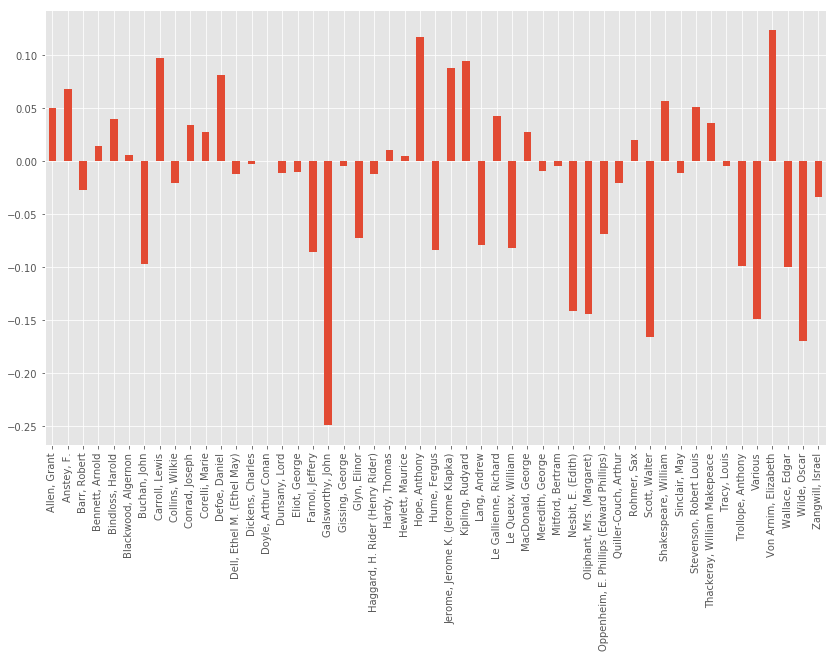

In [64]:
meanLatenessesSeries = pd.Series(meanLatenesses)
meanLatenessesSeries.plot(kind='bar')

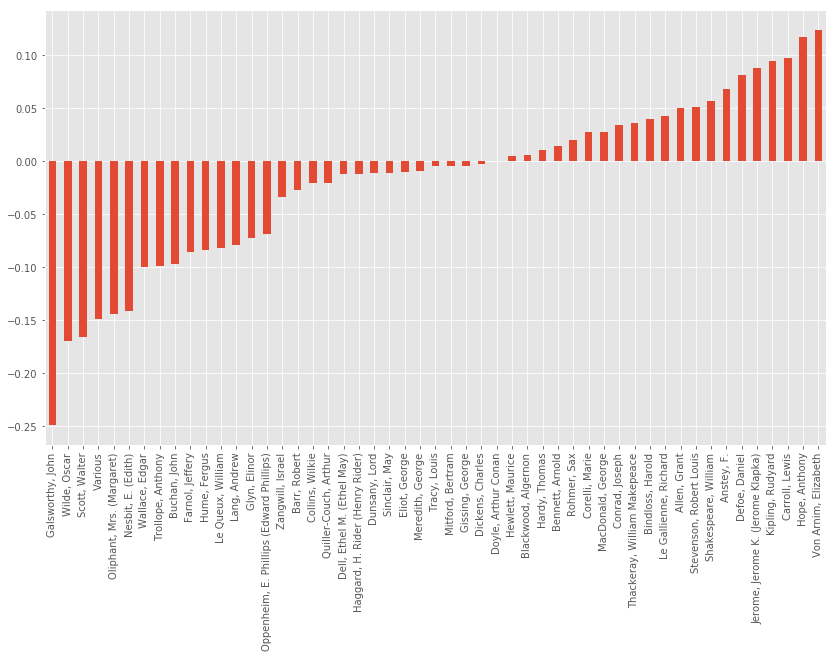

In [65]:
meanLatenessesSeries.sort_values().plot(kind='bar')

In [66]:
meanLatenessesSeries.mean()

-0.017061156629697

In [67]:
meanPeriodicities = {author: np.mean(pList) for author, pList in periodicities.items()}

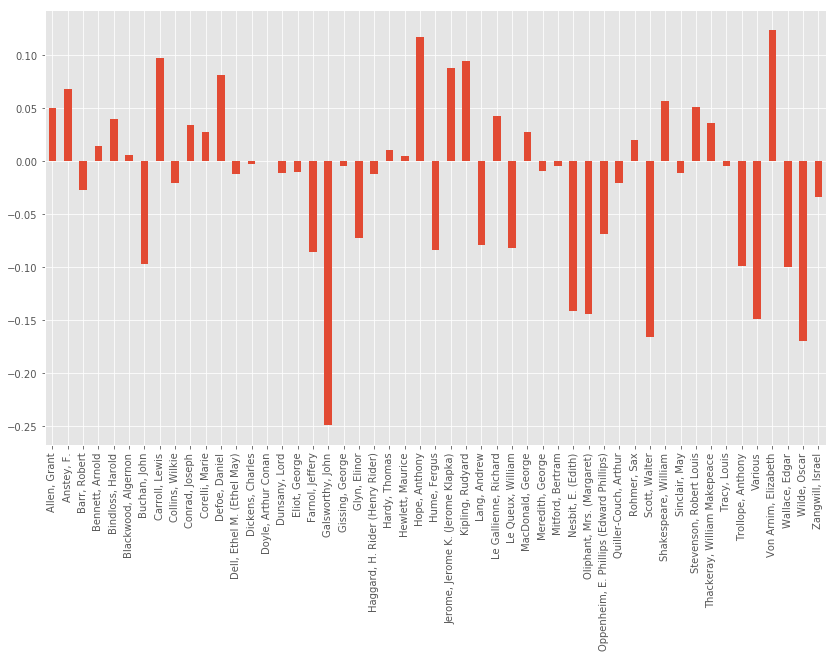

In [68]:
meanPeriodicitiesSeries = pd.Series(meanPeriodicities)
meanPeriodicitiesSeries.plot(kind='bar')

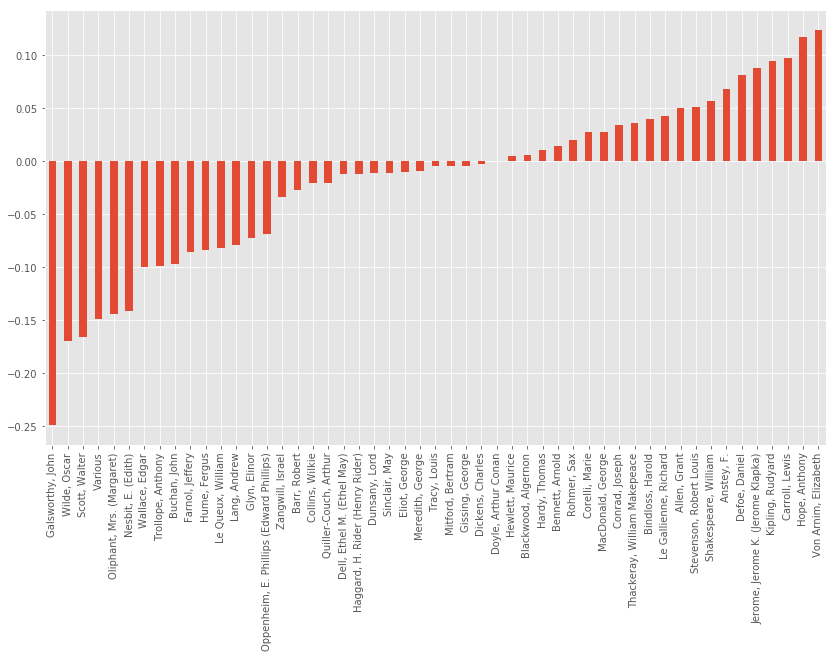

In [69]:
meanPeriodicitiesSeries.sort_values().plot(kind='bar')

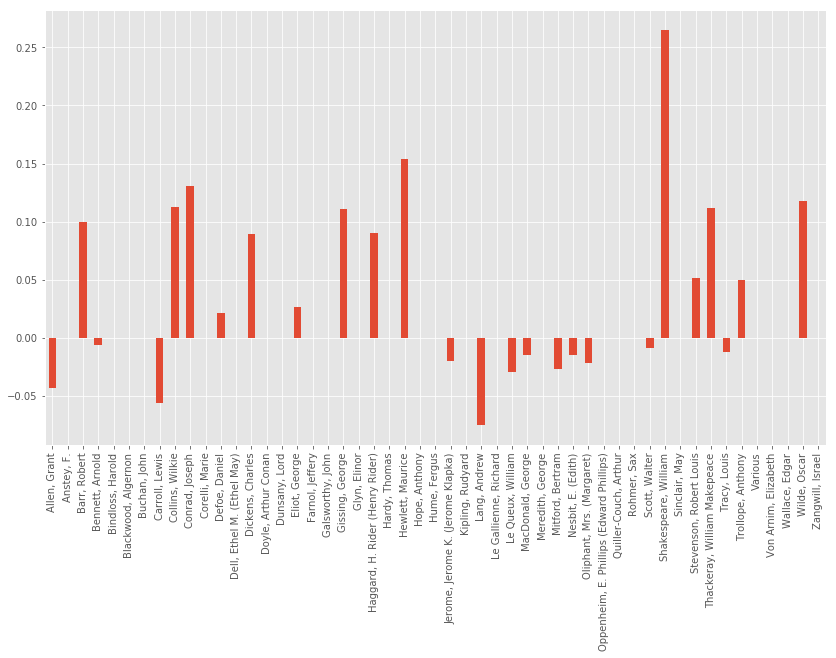

In [70]:
meanTddLatenesses = {author: np.mean(lateList) for author, lateList in tddLatenesses.items()}
meanTddLatenessesSeries = pd.Series(meanTddLatenesses)
meanTddLatenessesSeries.plot(kind='bar')

In [62]:
meanTddLatenessesSeries.mean()

0.021552029831437794

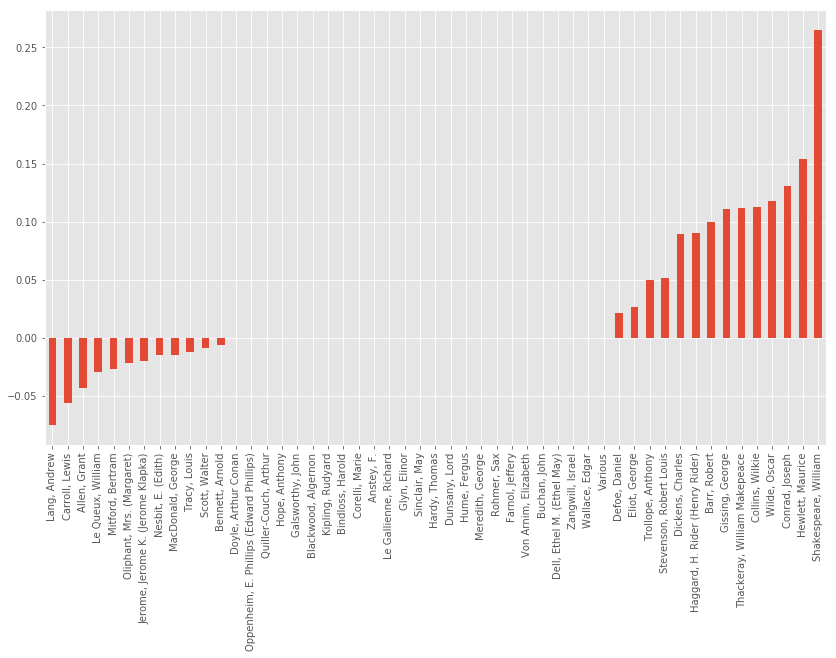

In [72]:
meanTddLatenessesSeries.sort_values().plot(kind='bar')

In [74]:
meanTddLatenessesSeries.mean()

0.021552029831437794